# Forecasting Traffic Volume - Creating and Evaluating Predictors: Part 1 - Target Time Series
**이 노트북의 원본은 https://github.com/chrisking/ForecastPOC.git 으로서, 원본 내용의 기반하에 추가 내용등을 기술한 버전 입니다.**

Summary: 
* Predictor 생성
    * ARIMA, Prophet, DeepAR+ 생성
* Predictor 평가
    * ARIMA, Prophet, DeepAR+의 RMSE, P10, P50, P90 확인
    * Backtest 평가 기간 (10.13 ~ 1.1) 까지의 실제 Traffic Volume 확인
    * Predictor 생성 및 BackTesting (4번)의 종합 실행 결과 (10.13 ~ 1.1) 확인
* Forecast 생성 및 포케스터 결과를 S3 에 업로드
    * ARIMA, Prophet, DeepAR+ Forecast 생성
    * ARIMA 예측 결과 확인 (실제값, P10, P50, P90)
    * Prophet 예측 결과 확인 (실제값, P10, P50, P90)
    * DeepAR 예측 결과 확인 (실제값, P10, P50, P90)
* 알고리즘 (ARIMA, Prophet, DeepAR+) 포케스팅 결과 비교
    * Arima Vs. Prophet with Target Data during Fri to Sun
    * Arima Vs. DeepAR+ with Target Data during Fri to Sun
    

# Creating and Evaluating Predictors: Part 1 - Target Time Series

This notebook will build off of the earlier data processing that was performed in the validation sessions. If you have not completed that part yet, go back to `Validating_and_Importing_Target_Time_Series_Data.ipynb` and complete it first before resuming.

At this point you have target-time-series data loaded into Amazon Forecast inside a Dataset Group, this is what is required to use all of the models within Amazon Forecast. As an initial exploration **we will evaluate the results from ARIMA, Prophet, and DeepAR+.** We could have also included ETS but have left it out for time constraints, similarly NPTS was left out as it specializes on spiky data or large gaps which our dataset does not have.

The very first thing to do is start with our imports, establish a connection to the Forecast service, and then restore our variables from before. The cells below will do that.

In [2]:
import boto3
from time import sleep
import subprocess
import pandas as pd
import json
import time
import pprint
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

In [3]:
with open('/opt/ml/metadata/resource-metadata.json') as notebook_info:
    data = json.load(notebook_info)
    resource_arn = data['ResourceArn']
    region = resource_arn.split(':')[3]
print(region)

us-east-2


In [4]:
session = boto3.Session(region_name=region)
forecast = session.client(service_name='forecast')
forecast_query = session.client(service_name='forecastquery')

In [5]:
# 다른 노트북에서 저장된 변수들을 불러옴
%store -r

## Creating and Training Predictors
 
Given that that our data is hourly and we want to generate a forecast on the hour, Forecast limits us to a horizon of 500 of whatever the slice is. This means we will be able to predict about 20 days into the future.

The cells below will define a few variables to be used with all of our models. Then there will be an API call to create each `Predictor` where they are based on ARIMA, Prophet, and DeepAR+ respectfully.



In [43]:
forecastHorizon = 480 # 예측할 시간의 갯수 (480시간 == 20일)
NumberOfBacktestWindows = 4 # Backtest를 하는 횟수
BackTestWindowOffset = 480 # Backtest의 평가(Evaluation)의 갯수
ForecastFrequency = "H"

아래 파라미터의 상세 정보는 [여기](https://docs.aws.amazon.com/forecast/latest/dg/metrics.html) 를 보세요.
![ForecastHorizon](static/imgs/ForecastHorizon.png)
![BackTest](static/imgs/BackTest.png)

In [7]:
arima_algorithmArn = 'arn:aws:forecast:::algorithm/ARIMA'
prophet_algorithmArn = 'arn:aws:forecast:::algorithm/Prophet'
deepAR_Plus_algorithmArn = 'arn:aws:forecast:::algorithm/Deep_AR_Plus'

### ARIMA

In [8]:
# ARIMA Specifics
arima_predictorName= project+'_arima_algo_1'

In [27]:
# Build ARIMA:
arima_create_predictor_response=forecast.create_predictor(PredictorName=arima_predictorName, 
                                                  AlgorithmArn=arima_algorithmArn,
                                                  ForecastHorizon=forecastHorizon,
                                                  PerformAutoML= False,
                                                  PerformHPO=False,
                                                  EvaluationParameters= {"NumberOfBacktestWindows": NumberOfBacktestWindows, 
                                                                         "BackTestWindowOffset": BackTestWindowOffset}, 
                                                  InputDataConfig= {"DatasetGroupArn": datasetGroupArn, "SupplementaryFeatures": [ 
                                                                     { 
                                                                        "Name": "holiday",
                                                                        "Value": "US"
                                                                     }
                                                                  ]},
                                                  FeaturizationConfig= {"ForecastFrequency": ForecastFrequency, 
                                                                        "Featurizations": 
                                                                        [
                                                                          {"AttributeName": "target_value", 
                                                                           "FeaturizationPipeline": 
                                                                            [
                                                                              {"FeaturizationMethodName": "filling", 
                                                                               "FeaturizationMethodParameters": 
                                                                                {"frontfill": "none", 
                                                                                 "middlefill": "zero", 
                                                                                 "backfill": "zero"}
                                                                              }
                                                                            ]
                                                                          }
                                                                        ]
                                                                       }
                                                 )



### Prophet

In [9]:
# Prophet Specifics
prophet_predictorName= project+'_prophet_algo_1'

In [29]:
# Build Prophet:
prophet_create_predictor_response=forecast.create_predictor(PredictorName=prophet_predictorName, 
                                                  AlgorithmArn=prophet_algorithmArn,
                                                  ForecastHorizon=forecastHorizon,
                                                  PerformAutoML= False,
                                                  PerformHPO=False,
                                                  EvaluationParameters= {"NumberOfBacktestWindows": NumberOfBacktestWindows, 
                                                                         "BackTestWindowOffset": BackTestWindowOffset}, 
                                                  InputDataConfig= {"DatasetGroupArn": datasetGroupArn, "SupplementaryFeatures": [ 
                                                                     { 
                                                                        "Name": "holiday",
                                                                        "Value": "US"
                                                                     }
                                                                  ]},
                                                  FeaturizationConfig= {"ForecastFrequency": ForecastFrequency, 
                                                                        "Featurizations": 
                                                                        [
                                                                          {"AttributeName": "target_value", 
                                                                           "FeaturizationPipeline": 
                                                                            [
                                                                              {"FeaturizationMethodName": "filling", 
                                                                               "FeaturizationMethodParameters": 
                                                                                {"frontfill": "none", 
                                                                                 "middlefill": "zero", 
                                                                                 "backfill": "zero"}
                                                                              }
                                                                            ]
                                                                          }
                                                                        ]
                                                                       }
                                                 )




### DeepAR+

In [10]:
# DeepAR+ Specifics
prophet_predictorName= project+'_deeparp_algo_1'

In [31]:
# Build DeepAR+:
deeparp_create_predictor_response=forecast.create_predictor(PredictorName=prophet_predictorName, 
                                                  AlgorithmArn=deepAR_Plus_algorithmArn,
                                                  ForecastHorizon=forecastHorizon,
                                                  PerformAutoML= False,
                                                  PerformHPO=False,
                                                  EvaluationParameters= {"NumberOfBacktestWindows": NumberOfBacktestWindows, 
                                                                         "BackTestWindowOffset": BackTestWindowOffset}, 
                                                  InputDataConfig= {"DatasetGroupArn": datasetGroupArn, "SupplementaryFeatures": [ 
                                                                     { 
                                                                        "Name": "holiday",
                                                                        "Value": "US"
                                                                     }
                                                                  ]},
                                                  FeaturizationConfig= {"ForecastFrequency": ForecastFrequency, 
                                                                        "Featurizations": 
                                                                        [
                                                                          {"AttributeName": "target_value", 
                                                                           "FeaturizationPipeline": 
                                                                            [
                                                                              {"FeaturizationMethodName": "filling", 
                                                                               "FeaturizationMethodParameters": 
                                                                                {"frontfill": "none", 
                                                                                 "middlefill": "zero", 
                                                                                 "backfill": "zero"}
                                                                              }
                                                                            ]
                                                                          }
                                                                        ]
                                                                       }
                                                 )





Normally in our notebooks we would have a while loop that polls for each of these to determine the status of the models in training. For simplicity sake here we are going to rely on you opening a new browser tab and following along in the console until a predictor has been created for each algorithm. 

Your previous tab from opening this session of Jupyter Lab should still be open, from there navigate to the Amazon Forecast service page, then select your dataset group. Lastly click `Predictors` and you should see the creation in progress. Once they are active you are ready to continue.

### Arima, Prophet, DeepAR+ Predictor를 생성한 후의 콘솔 화면

![Predictor 생성 상태](static/imgs/TargetPredictor.png)

## Examining the Predictors

Once each of the Predictors is in an `Active` state you can get metrics about it to better understand its accuracy and behavior. These are computed based on the hold out periods we defined when building the Predictor. The metrics are meant to guide our decisions when we use a particular Predictor to generate a forecast

### ARIMA

ARIMA is one of the gold standards for time series forecasting. This algorithm is not particularly sophisticated but it is reliable and can help us understand a baseline of performance. **To note it does not really understand seasonality very well and it does not support any item metadata or related time series information.** Due to that we will explore it here but not after adding other datasets.

In [33]:
# ARIMA Metrics
arima_arn = arima_create_predictor_response['PredictorArn']
arima_metrics = forecast.get_accuracy_metrics(PredictorArn=arima_arn)
pp = pprint.PrettyPrinter()
pp.pprint(arima_metrics)

{'PredictorEvaluationResults': [{'AlgorithmArn': 'arn:aws:forecast:::algorithm/ARIMA',
                                 'TestWindows': [{'EvaluationType': 'SUMMARY',
                                                  'Metrics': {'RMSE': 2315.5733958045107,
                                                              'WeightedQuantileLosses': [{'LossValue': 0.29069288281337363,
                                                                                          'Quantile': 0.9},
                                                                                         {'LossValue': 0.35619575117523433,
                                                                                          'Quantile': 0.5},
                                                                                         {'LossValue': 0.18638100224895027,
                                                                                          'Quantile': 0.1}]}},
                                             

### Prophet

Same as ARIMA, now you should look at the metrics from it.

In [34]:
# Prophet Metrics
prophet_arn = prophet_create_predictor_response['PredictorArn']
prophet_metrics = forecast.get_accuracy_metrics(PredictorArn=prophet_arn)
pp = pprint.PrettyPrinter()
pp.pprint(prophet_metrics)

{'PredictorEvaluationResults': [{'AlgorithmArn': 'arn:aws:forecast:::algorithm/Prophet',
                                 'TestWindows': [{'EvaluationType': 'SUMMARY',
                                                  'Metrics': {'RMSE': 2332.0433768235803,
                                                              'WeightedQuantileLosses': [{'LossValue': 0.28611803399397134,
                                                                                          'Quantile': 0.9},
                                                                                         {'LossValue': 0.38790491755537837,
                                                                                          'Quantile': 0.5},
                                                                                         {'LossValue': 0.15621042054818188,
                                                                                          'Quantile': 0.1}]}},
                                           

### DeepAR+

Same as Prophet and ARIMA, now you should look at the metrics from it.

In [35]:
# DeepAR+ Metrics
deeparp_arn = deeparp_create_predictor_response['PredictorArn']
deeparp_metrics = forecast.get_accuracy_metrics(PredictorArn=deeparp_arn)
pp = pprint.PrettyPrinter()
pp.pprint(deeparp_metrics)

{'PredictorEvaluationResults': [{'AlgorithmArn': 'arn:aws:forecast:::algorithm/Deep_AR_Plus',
                                 'TestWindows': [{'EvaluationType': 'SUMMARY',
                                                  'Metrics': {'RMSE': 2326.8674915595398,
                                                              'WeightedQuantileLosses': [{'LossValue': 0.29921268639444615,
                                                                                          'Quantile': 0.9},
                                                                                         {'LossValue': 0.2779019517382061,
                                                                                          'Quantile': 0.5},
                                                                                         {'LossValue': 0.09644074167524376,
                                                                                          'Quantile': 0.1}]}},
                                       

## Predictor 평가

### Backtest 평가 기간 (10.13 ~ 1.1) 까지의 실제 Traffic Volume
추세는 갈수록 교통량이 줄어들고 있음. 10.13 ~ 11.02 는 약 2.0 million, 12.12 ~ 1.1 는 약 1.7 million으로 줄어듬

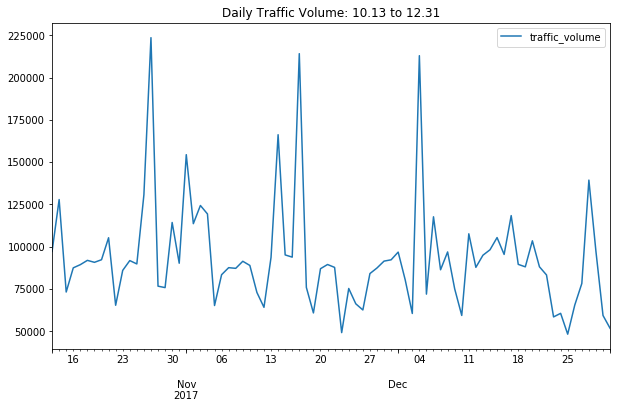

In [11]:
target_time_series_df_1013 = target_time_series_df['2017-10-13':]
target_time_series_df_1013.resample('D').sum().plot(title="Daily Traffic Volume: 10.13 to 12.31",
                                                    figsize=(10,6)
                                                   )

In [12]:
print(target_time_series_df_1013.resample('20D').sum())

            traffic_volume
2017-10-13       2054838.0
2017-11-02       1975285.0
2017-11-22       1762833.0
2017-12-12       1712384.0


## Predictor 생성 및 BackTesting (4번)의 종합 실행 결과 (10.13 ~ 1.1)

* Implication
    * 전체 평가 기간(10.13 ~ 12.31) 기간 동안 ARIMA 2315 로 가장 우수
    * Traffic Volume이 줄어드는 11.22 ~ 12.12 와 12.12 ~ 1.1  에는 DeepAR+ 이 우수


![ARIMA, Prophet, DeepAR+ RMSE](static/imgs/TargetBackTestRMSE.png)

Pridictor에서 제공하는 P10, P50, P90 의 평가값들도 확인할 수 있음

![ARIMA, Prophet, DeepAR+ p10,p50,p90](static/imgs/TargetPredictorPMetric.png)


## Creating and Exporting Forecasts

Inside Amazon Forecast **a Forecast is a rendered collection of all of your items, at every time interval, for all selected quantiles, for your given forecast horizon.** This process takes the Predictor you just created and uses it to generate these inferences and to store them in a useful state. Once a Forecast exists within the service you can query it and obtain a JSON response or use another API call to export it to a CSV that is stored in S3. 

This tutorial will focus on the S3 Export as that is often an easy way to manually explore the data with many tools.

These again will take some time to complete after you have executed the cells so explore the console to see when they have completed.

To do that visit the Amazon Forecast Service page, then clck your Dataset Group, and then click `Forecasts` on the left. They will say `Create in progress...` initially and then `Active` when ready for export.

In [36]:
# ARIMA
arima_forecastName = project+'_arima_algo_forecast'
arima_create_forecast_response=forecast.create_forecast(ForecastName=arima_forecastName,
                                                  PredictorArn=arima_arn)
arima_forecast_arn = arima_create_forecast_response['ForecastArn']

In [37]:
# Prophet
prophet_forecastName = project+'_prophet_algo_forecast'
prophet_create_forecast_response=forecast.create_forecast(ForecastName=prophet_forecastName,
                                                  PredictorArn=prophet_arn)
prophet_forecast_arn = prophet_create_forecast_response['ForecastArn']

In [38]:
# DeepAR+
deeparp_forecastName = project+'_deeparp_algo_forecast'
deeparp_create_forecast_response=forecast.create_forecast(ForecastName=deeparp_forecastName,
                                                  PredictorArn=deeparp_arn)
deeparp_forecast_arn = deeparp_create_forecast_response['ForecastArn']

Once they are `Active` you can start the export process. The code to do so is in the cells below. 

위의 과정이 완료되면 아래와 같이 3개의 Forecasts가 생성이 됨

![TargetForecasts](static/imgs/TargetForecasts.png)

### 콘솔에서 Forecast lookup 메뉴: DeepAR Forecast를 선택하고, 시작날짜 와 끝날짜를 입력 후의 결과

![ForecastLookup](static/imgs/ForecastLookupDeepAR.png)

### 예측결과를 S3에 업로드

In [40]:
arima_path = "s3://" + bucket_name + "/arima_1/"
arima_job_name = "ArimaExport1"
forecast.create_forecast_export_job(ForecastExportJobName=arima_job_name,
                                                        ForecastArn=arima_forecast_arn,
                                                        Destination={
                                                            "S3Config" : {
                                                                "Path": arima_path,
                                                                "RoleArn": role_arn
                                                            }
                                                        })

{'ForecastExportJobArn': 'arn:aws:forecast:us-east-2:057716757052:forecast-export-job/forecast_poc_gsmoon_arima_algo_forecast/ArimaExport1',
 'ResponseMetadata': {'RequestId': '80ca31d2-ed21-4278-b82a-6b9faa9badbe',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Mon, 09 Mar 2020 06:43:46 GMT',
   'x-amzn-requestid': '80ca31d2-ed21-4278-b82a-6b9faa9badbe',
   'content-length': '139',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

In [41]:
prophet_path = "s3://" + bucket_name + "/prophet_1/"
prophet_job_name = "ProphetExport1"
forecast.create_forecast_export_job(ForecastExportJobName=prophet_job_name,
                                                        ForecastArn=prophet_forecast_arn,
                                                        Destination={
                                                            "S3Config" : {
                                                                "Path": prophet_path,
                                                                "RoleArn": role_arn
                                                            }
                                                        })

{'ForecastExportJobArn': 'arn:aws:forecast:us-east-2:057716757052:forecast-export-job/forecast_poc_gsmoon_prophet_algo_forecast/ProphetExport1',
 'ResponseMetadata': {'RequestId': 'e9804649-c977-44b9-b22e-df50e40864ea',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Mon, 09 Mar 2020 06:44:00 GMT',
   'x-amzn-requestid': 'e9804649-c977-44b9-b22e-df50e40864ea',
   'content-length': '143',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

In [42]:
deeparp_path = "s3://" + bucket_name + "/deeparp_1/"
deeparp_job_name = "DeepARPExport1"
forecast.create_forecast_export_job(ForecastExportJobName=deeparp_job_name,
                                                        ForecastArn=deeparp_forecast_arn,
                                                        Destination={
                                                            "S3Config" : {
                                                                "Path": deeparp_path,
                                                                "RoleArn": role_arn
                                                            }
                                                        })

{'ForecastExportJobArn': 'arn:aws:forecast:us-east-2:057716757052:forecast-export-job/forecast_poc_gsmoon_deeparp_algo_forecast/DeepARPExport1',
 'ResponseMetadata': {'RequestId': '3ea76df5-c467-4c28-bb5d-1ca312725135',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Mon, 09 Mar 2020 06:44:04 GMT',
   'x-amzn-requestid': '3ea76df5-c467-4c28-bb5d-1ca312725135',
   'content-length': '143',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

This exporting process is another one of those items that will take several minutes to complete. Just poll for progress in the console. From the earlier page where you saw the status turn `Active` for a Forecast, click it and you can see the progress of the export.

### Obtaining the Forecasts

At this point they are all exported into S3 but you need to obtain the results locally so we can explore them, the cells below will do that starting with ARIMA, then Prophet, and lastly DeepAR+.

In [13]:
# Arima
s3 = boto3.resource('s3')
poc_bucket = boto3.resource('s3').Bucket(bucket_name)
arima_filename = ""
arima_files = list(poc_bucket.objects.filter(Prefix="arima_1"))
print("arima_files: ",arima_files )
for file in arima_files:
    # There will be a collection of CSVs if the forecast is large, modify this to go get them all
    if "csv" in file.key:
        arima_filename = file.key.split('/')[1]
        s3.Bucket(bucket_name).download_file(file.key, data_dir+"/"+arima_filename)

print( "data file path: ", data_dir+"/"+arima_filename)        
print("bucket_name: ", bucket_name)
print(arima_filename)

arima_files:  [s3.ObjectSummary(bucket_name='057716757052forecastpoc-gsmoon', key='arima_1/ArimaExport1_2020-03-09T06-46-28Z_part0.csv'), s3.ObjectSummary(bucket_name='057716757052forecastpoc-gsmoon', key='arima_1/_CHECK'), s3.ObjectSummary(bucket_name='057716757052forecastpoc-gsmoon', key='arima_1/_SUCCESS')]
data file path:  data/ArimaExport1_2020-03-09T06-46-28Z_part0.csv
bucket_name:  057716757052forecastpoc-gsmoon
ArimaExport1_2020-03-09T06-46-28Z_part0.csv


In [14]:
# Prophet
s3 = boto3.resource('s3')
poc_bucket = boto3.resource('s3').Bucket(bucket_name)
prophet_filename = ""
prophet_files = list(poc_bucket.objects.filter(Prefix="prophet_1"))
for file in prophet_files:
    # There will be a collection of CSVs if the forecast is large, modify this to go get them all
    if "csv" in file.key:
        prophet_filename = file.key.split('/')[1]
        s3.Bucket(bucket_name).download_file(file.key, data_dir+"/"+prophet_filename)
print(prophet_filename)

ProphetExport1_2020-03-09T06-46-54Z_part0.csv


In [15]:
# DeepAR+
s3 = boto3.resource('s3')
poc_bucket = boto3.resource('s3').Bucket(bucket_name)
deeparp_filename = ""
deeparp_files = list(poc_bucket.objects.filter(Prefix="deeparp_1"))
for file in deeparp_files:
    # There will be a collection of CSVs if the forecast is large, modify this to go get them all
    if "csv" in file.key:
        deeparp_filename = file.key.split('/')[1]
        s3.Bucket(bucket_name).download_file(file.key, data_dir+"/"+deeparp_filename)
print(deeparp_filename)

DeepARPExport1_2020-03-09T06-46-52Z_part0.csv


### ARIMA Validation

In [16]:
# ARIMA Eval
arima_predicts = pd.read_csv(data_dir+"/"+arima_filename)
arima_predicts.sample()

,item_id,date,p10,p50,p90
290,1,2018-01-13T02:00:00Z,-2377.187855,116.867757,2610.923369


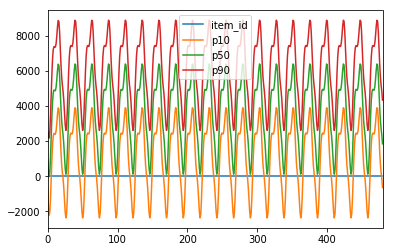

In [17]:
arima_predicts.plot()

In [18]:
# Convert the column to datetime
arima_predicts['date'] = pd.to_datetime(arima_predicts['date'])

In [19]:
arima_predicts.sample()

,item_id,date,p10,p50,p90
100,1,2018-01-05 04:00:00+00:00,-1330.220141,1163.835471,3657.891083


In [20]:
# Remove the timezone and make date the index
arima_predicts['date'] = arima_predicts['date'].dt.tz_convert(None)
arima_predicts.set_index('date', inplace=True)

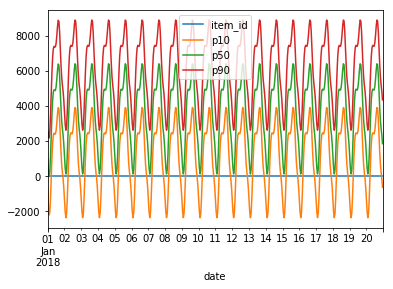

In [21]:
arima_predicts.plot()

In [22]:
print (arima_predicts.index.min())
print (arima_predicts.index.max())

2018-01-01 00:00:00
2018-01-20 23:00:00


Here we can see our prediction goes from Jan 01 to Jan 20 as expectged given our 480 interval forecast horizon. Also we can see the cyclical nature of the predictions over. the entire timeframe. 

Now we are going to create a dataframe of the prediction values from this Forecast and the actual values.

First let us remove the column ID of item before continuing.

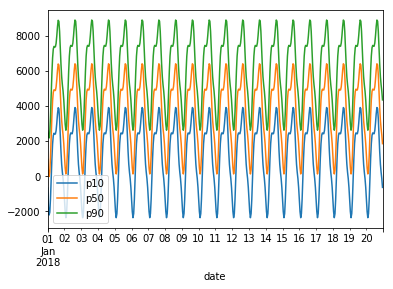

In [23]:
arima_predicts = arima_predicts[['p10', 'p50', 'p90']]
arima_predicts.plot()

2018-01-01 00:00:00
2018-01-20 23:00:00


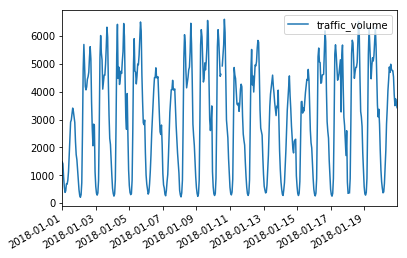

In [24]:
# Lets slice validation to meet our needs
validation_df = validation_time_series_df.copy()
validation_df = validation_df.loc['2018-01-01':'2018-01-20']
print (validation_df.index.min())
print (validation_df.index.max())
validation_df.plot()

In [25]:
# Finally let us join the dataframes together
arima_val_df = arima_predicts.join(validation_df, how='outer')

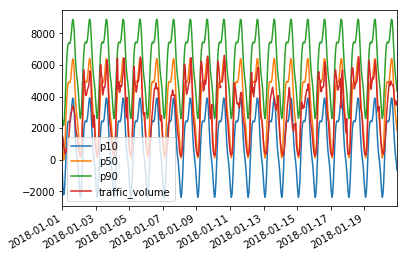

In [26]:
# Plot
arima_val_df.plot()

Given that this particular plot is hard to see, let us pick a random day January 5th to compare.

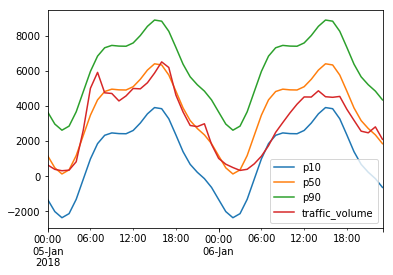

In [27]:
arima_val_df_jan_5 = arima_val_df.loc['2018-01-05':'2018-01-06']
arima_val_df_jan_5.plot()

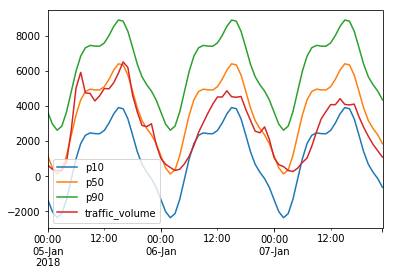

In [28]:
arima_val_df_jan_5_7 = arima_val_df.loc['2018-01-05':'2018-01-07']
arima_val_df_jan_5_7.plot()

Now this is pretty clear for p50 showcasing that it does a great job of predicting the volume. Let us now do this for Prophet and DeepAR+.

### Prophet Validation

We will speed up the prep work to just a few cells this time.

In [29]:
# Prophet Eval
prophet_predicts = pd.read_csv(data_dir+"/"+prophet_filename)
prophet_predicts.sample()
# Remove the timezone
prophet_predicts['date'] = pd.to_datetime(prophet_predicts['date'])
prophet_predicts['date'] = prophet_predicts['date'].dt.tz_convert(None)
prophet_predicts.set_index('date', inplace=True)
prophet_predicts = prophet_predicts[['p10', 'p50', 'p90']]
# Finally let us join the dataframes together
prophet_val_df = prophet_predicts.join(validation_df, how='outer')

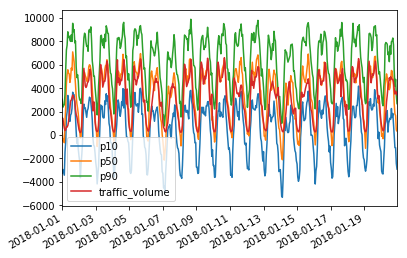

In [30]:
# Plot
prophet_val_df.plot()

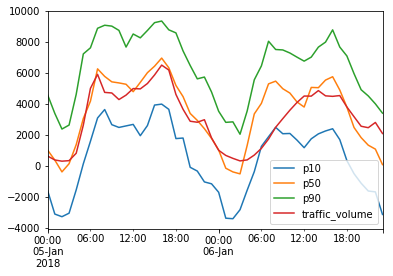

In [31]:
prophet_val_df_jan_5 = prophet_val_df.loc['2018-01-05':'2018-01-06']
prophet_val_df_jan_5.plot()

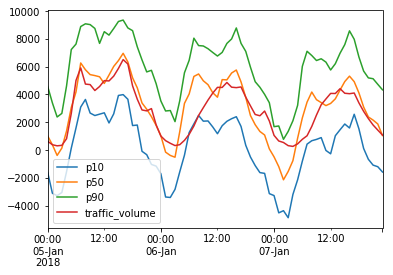

In [32]:
prophet_val_df_jan_5_7 = prophet_val_df.loc['2018-01-05':'2018-01-07']
prophet_val_df_jan_5_7.plot()

### DeepAR+ Validation

In [33]:
# DeepAR+ Eval
deeparp_predicts = pd.read_csv(data_dir+"/"+deeparp_filename)
deeparp_predicts.sample()
# Remove the timezone
deeparp_predicts['date'] = pd.to_datetime(deeparp_predicts['date'])
deeparp_predicts['date'] = deeparp_predicts['date'].dt.tz_convert(None)
deeparp_predicts.set_index('date', inplace=True)
deeparp_predicts = deeparp_predicts[['p10', 'p50', 'p90']]
# Finally let us join the dataframes together
deeparp_val_df = deeparp_predicts.join(validation_df, how='outer')

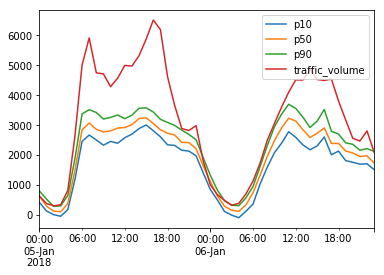

In [34]:
deeparp_val_df_jan_5 = deeparp_val_df.loc['2018-01-05':'2018-01-06']
deeparp_val_df_jan_5.plot()

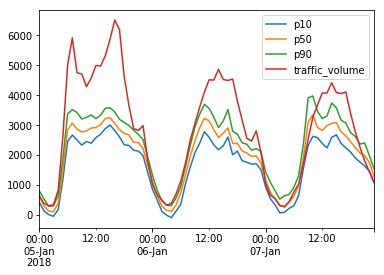

In [35]:
deeparp_val_df_jan_5_7 = deeparp_val_df.loc['2018-01-05':'2018-01-07']
deeparp_val_df_jan_5_7.plot()

What is particularly interesting here is that we were below the actual numbers for a good portion of the day even with p90. We did see great performance from Prophet and the metrics indicate that DeepAR+ is objectively better here so now we will add related time series data to our project and see how the models behave then.

### 알고리즘 (ARIMA, Prophet, DeepAR+) 포케스팅 결과 비교

In [36]:
def show_two_chart_horizontal(title, df1, sub_title1, df2, sub_title2):
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.suptitle(title)

    fig.set_figwidth(16)
    fig.set_figheight(4)

    ax1.title.set_text(sub_title1)
    ax2.title.set_text(sub_title2)
    df1.plot(ax=ax1)
    df2.plot(ax=ax2)    

#### Arima Vs. Prophet with Target Data during Fri to Sun

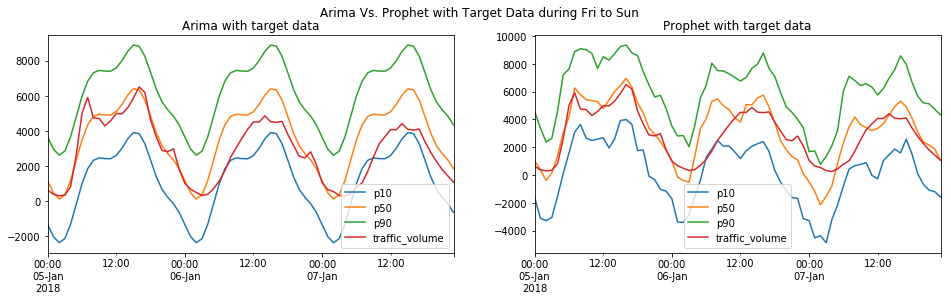

In [39]:
show_two_chart_horizontal("Arima Vs. Prophet with Target Data during Fri to Sun", 
                          arima_val_df_jan_5_7, 
                          "Arima with target data", 
                          prophet_val_df_jan_5_7,
                          "Prophet with target data", 
                         )


#### Arima Vs. DeepAR+ with Target Data during Fri to Sun

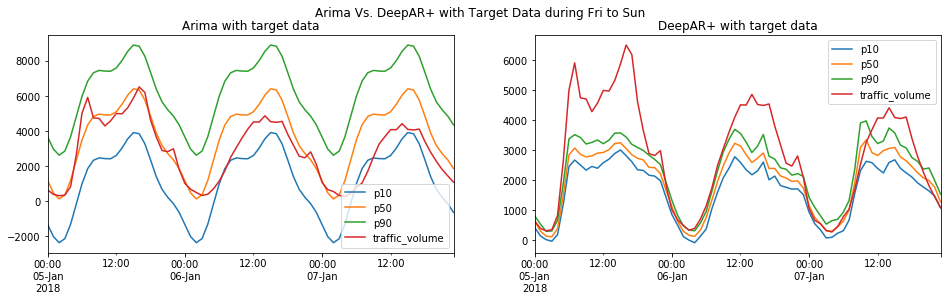

In [37]:
show_two_chart_horizontal("Arima Vs. DeepAR+ with Target Data during Fri to Sun", 
                          arima_val_df_jan_5_7, 
                          "Arima with target data", 
                          deeparp_val_df_jan_5_7,
                          "DeepAR+ with target data", 
                         )


#### Prophet Vs. DeepAR+ with Target Data during Fri to Sun

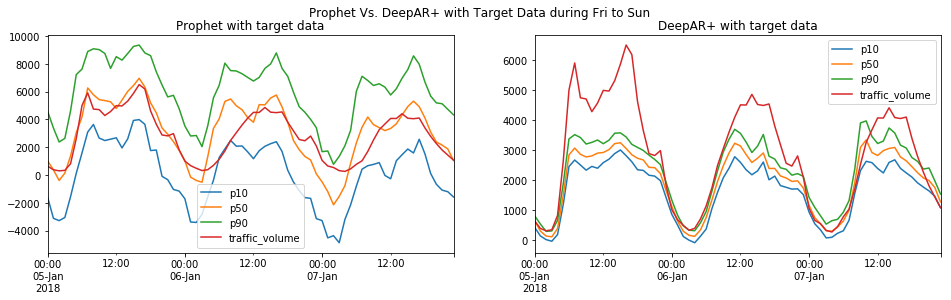

In [38]:
show_two_chart_horizontal("Prophet Vs. DeepAR+ with Target Data during Fri to Sun", 
                          prophet_val_df_jan_5_7, 
                          "Prophet with target data", 
                          deeparp_val_df_jan_5_7,
                          "DeepAR+ with target data", 
                         )


## Recap and Next Steps

At this point we can now see through the 3 plots below that DeepAR+ does a really good job outside of the high ranges, and that perhaps adding related data could improve both Prophet and DeepAR+'s performance. The next thing to do is to move to the notebook for importing your related-time series data and then progress to the second Creating and Evaluating notebook that will explain how to leverage the related data.

### Store Variable

In [40]:
%store arima_val_df_jan_5
%store prophet_val_df_jan_5
%store deeparp_val_df_jan_5

%store arima_val_df_jan_5_7
%store prophet_val_df_jan_5_7
%store deeparp_val_df_jan_5_7

Stored 'arima_val_df_jan_5' (DataFrame)
Stored 'prophet_val_df_jan_5' (DataFrame)
Stored 'deeparp_val_df_jan_5' (DataFrame)
Stored 'arima_val_df_jan_5_7' (DataFrame)
Stored 'prophet_val_df_jan_5_7' (DataFrame)
Stored 'deeparp_val_df_jan_5_7' (DataFrame)
